In [6]:

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, BatchNormalization, LeakyReLU
from keras.layers.merge import concatenate
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
# from tensorflow import set_random_seed
import tensorflow as tf
from skimage.io import imread
from PIL import Image
from skimage.transform import resize
from tensorflow.keras.applications.vgg16 import VGG16
from keras.layers import *
import image_utils as iu
# import image_utils as iufrom tensorflow_examples.models.pix2pix import pix2pix
tf.config.experimental_run_functions_eagerly(True)


In [2]:
data_path = 'data'


In [3]:
x_train_data_path = os.path.join(
    data_path, 'Human-Segmentation', 'Training_Images')
y_train_data_path = os.path.join(
    data_path, 'Human-Segmentation', 'Ground_Truth')


In [4]:
import re


def tryint(s):
    try:
        return int(s)
    except:
        return s


def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    return [tryint(c) for c in re.split('([0-9]+)', s)]


In [7]:
x_train_images_path = iu.get_all_files(x_train_data_path)
y_train_images_path = iu.get_all_files(y_train_data_path)
x_train_images_path.sort(key=alphanum_key)
y_train_images_path.sort(key=alphanum_key)


In [8]:
x_train_images = []
y_train_images = []

for x in range(len(x_train_images_path)):
    try:
       x_train_images.append(iu.read_image(os.path.join(x_train_data_path, x_train_images_path[x]), 'RGB'))
       y_train_images.append(iu.read_image(os.path.join(
          y_train_data_path, y_train_images_path[x]), 'RGB'))
    except:
       pass



In [9]:
print('train size:', len(x_train_images))

train size: 290


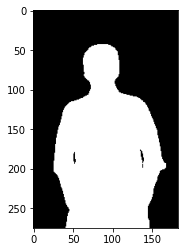

In [10]:
iu.display_image(y_train_images[6])

In [12]:
def pad_image(image, max_size):
    old_image_height, old_image_width, channels = image.shape
    # create new image of desired size and color (blue) for padding
    new_image_width = max_size
    new_image_height = max_size
    color = (0, 0, 0)
    result = np.full((new_image_height, new_image_width,
                      channels), color, dtype=np.uint8)
    # compute center offset
    x_center = (new_image_width - old_image_width) // 2
    y_center = (new_image_height - old_image_height) // 2
    # print(image)
    # copy img image into center of result image
    # result[y_center:y_center+old_image_height,x_center:x_center+old_image_width] = image
    result[0:old_image_height, 0:old_image_width] = image
    return result


In [13]:
# resize the image. The aspect ratio of the image is maintained.
for x in range(len(x_train_images)):
    new_dimen = 240;
    new_width, new_height = iu.get_new_image_dimen(x_train_images[x], new_dimen)
    # resize(images[x], new_width, new_height)
    x_train_images[x] = x_train_images[x].resize((int(new_width), int(new_height)))
    y_train_images[x] = y_train_images[x].resize(
        (int(new_width), int(new_height)))


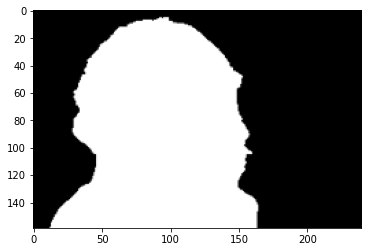

In [14]:
# display resized image
iu.display_image(y_train_images[0])

In [15]:
#images are converted to numpy arrays to be padded.
for x in range(len(x_train_images)):
    x_train_images[x] = np.asarray(x_train_images[x])
    y_train_images[x] = np.asarray(y_train_images[x])

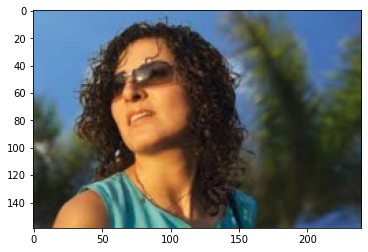

In [16]:
# display resized image
iu.display_image(x_train_images[0])


In [17]:
# since the images do not have the same aspect ratios,
# the image is padded to have the same aspect ratios. 
for x in range(len(x_train_images)):
    x_train_images[x] = iu.pad_image(x_train_images[x], 240)
    y_train_images[x] = iu.pad_image(y_train_images[x], 240)


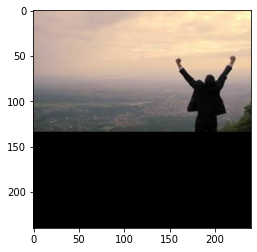

In [18]:
# display padded image
iu.display_image(x_train_images[1])


In [19]:
x_train_images = np.array((x_train_images)) / 255
y_train_images = np.array(y_train_images) / 255

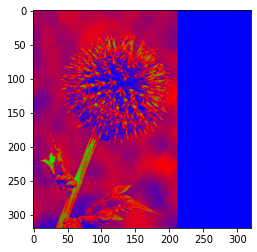

In [46]:
iu.display_image(train_images_y_channel[0])

In [ ]:
## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False,
                   input_shape=(96, 96, 3), input_tensor=Input(shape=(150, 150, 3)))
base_model.trainable = False  # Not trainable weights
base_model.summary()


In [41]:
images.shape

(4317,)

In [37]:
images

array([array([[[0.69803922, 0.4745098 , 0.54901961],
               [0.69411765, 0.4745098 , 0.54901961],
               [0.69019608, 0.4745098 , 0.54901961],
               ...,
               [0.85098039, 0.47843137, 0.51764706],
               [0.85098039, 0.47843137, 0.52156863],
               [0.85098039, 0.47843137, 0.52156863]],

              [[0.69803922, 0.4745098 , 0.54901961],
               [0.69411765, 0.4745098 , 0.54901961],
               [0.69019608, 0.4745098 , 0.54901961],
               ...,
               [0.85098039, 0.47843137, 0.51764706],
               [0.85098039, 0.47843137, 0.52156863],
               [0.85098039, 0.47843137, 0.52156863]],

              [[0.69803922, 0.4745098 , 0.54901961],
               [0.69411765, 0.4745098 , 0.54901961],
               [0.69019608, 0.4745098 , 0.54901961],
               ...,
               [0.85098039, 0.47843137, 0.51764706],
               [0.85098039, 0.47843137, 0.52156863],
               [0.85098039, 0.47843

In [63]:

#Encoder
encoder_input = Input(shape=(240, 240, 1,))
encoder_output = Conv2D(64, (3, 3), activation='relu',
                        padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3, 3), activation='relu',
                        padding='same')(encoder_output)
encoder_output = Conv2D(128, (3, 3), activation='relu',
                        padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3, 3), activation='relu',
                        padding='same')(encoder_output)
encoder_output = Conv2D(256, (3, 3), activation='relu',
                        padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3, 3), activation='relu',
                        padding='same')(encoder_output)
encoder_output = Conv2D(512, (3, 3), activation='relu',
                        padding='same')(encoder_output)
encoder_output = Conv2D(256, (3, 3), activation='relu',
                        padding='same')(encoder_output)
#Decoder
decoder_output = Conv2D(128, (3, 3), activation='relu',
                        padding='same')(encoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = Conv2D(64, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = Conv2D(16, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = Conv2D(3, (3, 3), activation='sigmoid',
                        padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
model = Model(inputs=encoder_input, outputs=decoder_output)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 1)]     0         
                                                                 
 conv2d_13 (Conv2D)          (None, 120, 120, 64)      640       
                                                                 
 conv2d_14 (Conv2D)          (None, 120, 120, 128)     73856     
                                                                 
 conv2d_15 (Conv2D)          (None, 60, 60, 128)       147584    
                                                                 
 conv2d_16 (Conv2D)          (None, 60, 60, 256)       295168    
                                                                 
 conv2d_17 (Conv2D)          (None, 30, 30, 256)       590080    
                                                                 
 conv2d_18 (Conv2D)          (None, 30, 30, 512)       1180

In [340]:
#Encoder
encoder_input = Input(shape=(240, 240, 1,))
encoder_output = Conv2D(64, (3, 3), activation='relu',
                        padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3, 3), activation='relu',
                        padding='same')(encoder_output)
encoder_output = Conv2D(128, (3, 3), activation='relu',
                        padding='same', strides=2)(encoder_output)

encoder_output = MaxPooling2D(pool_size=(2, 2), padding='same')(encoder_output)

encoder_output = Conv2D(256, (3, 3), activation='relu',
                        padding='same')(encoder_output)
encoder_output = Conv2D(256, (3, 3), activation='relu',
                        padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3, 3), activation='relu',
                        padding='same')(encoder_output)

encoder_output = MaxPooling2D(pool_size=(2, 2), padding='same')(encoder_output)

encoder_output = Conv2D(512, (3, 3), activation='relu',
                        padding='same')(encoder_output)
encoder_output = Conv2D(256, (3, 3), activation='relu',
                        padding='same')(encoder_output)
encoder_output = Conv2D(256, (3, 3), activation='relu',
                        padding='same')(encoder_output)

encoder_output = MaxPooling2D(pool_size=(2, 2), padding='same')(encoder_output)

encoder_output = Conv2D(256, (3, 3), activation='relu',
                        padding='same')(encoder_output)
encoder_output = Conv2D(256, (3, 3), activation='relu',
                        padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3, 3), activation='relu',
                        padding='same')(encoder_output)

encoder_output = MaxPooling2D(pool_size=(2, 2), padding='same')(encoder_output)
encoder_output = Conv2D(128, (3, 3), activation='relu',
                        padding='same')(encoder_output)
encoder_output = Conv2D(128, (3, 3), activation='relu',
                        padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(64, (3, 3), activation='relu',
                        padding='same')(encoder_output)
encoder_output = MaxPooling2D(pool_size=(2, 2), padding='same')(encoder_output)
#Decoder
decoder_output = Conv2D(128, (3, 3), activation='relu',
                        padding='same')(encoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(128, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = Conv2D(128, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = UpSampling2D((4, 4))(decoder_output)
decoder_output = Conv2D(256, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = Conv2D(256, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = Conv2D(512, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = Conv2D(512, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = UpSampling2D((3, 3))(decoder_output)
decoder_output = Conv2D(256, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = Conv2D(128, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = Conv2D(128, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = UpSampling2D((5, 5))(decoder_output)
decoder_output = Conv2D(64, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = Conv2D(32, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = Conv2D(16, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = Conv2D(3, (3, 3), activation='sigmoid',
                        padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
model = Model(inputs=encoder_input, outputs=decoder_output)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()


Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 240, 240, 1)]     0         
                                                                 
 conv2d_271 (Conv2D)         (None, 120, 120, 64)      640       
                                                                 
 conv2d_272 (Conv2D)         (None, 120, 120, 128)     73856     
                                                                 
 conv2d_273 (Conv2D)         (None, 60, 60, 128)       147584    
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 30, 30, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_274 (Conv2D)         (None, 30, 30, 256)       295168    
                                                          

In [20]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    """
    This block uses multiple convolution layers, max pool, relu activation to create an architecture for learning. 
    Dropout can be added for regularization to prevent overfitting. 
    The block returns the activation values for next layer along with a skip connection which will be used in the decoder
    """
    # Add 2 Conv Layers with relu activation and HeNormal initialization using TensorFlow
    # Proper initialization prevents from the problem of exploding and vanishing gradients
    # 'Same' padding will pad the input to conv layer such that the output has the same height and width (hence, is not reduced in size)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)

    # Batch Normalization will normalize the output of the last layer based on the batch's mean and standard deviation
    conv = BatchNormalization()(conv, training=False)

    # In case of overfitting, dropout will regularize the loss and gradient computation to shrink the influence of weights on output
    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # Pooling reduces the size of the image while keeping the number of channels same
    # Pooling has been kept as optional as the last encoder layer does not use pooling (hence, makes the encoder block flexible to use)
    # Below, Max pooling considers the maximum of the input slice for output computation and uses stride of 2 to traverse across input image
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv)
    else:
        next_layer = conv

    # skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions
    skip_connection = conv

    return next_layer, skip_connection


def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    """
    Decoder Block first uses transpose convolution to upscale the image to a bigger size and then,
    merges the result with skip layer results from encoder block
    Adding 2 convolutions with 'same' padding helps further increase the depth of the network for better predictions
    The function returns the decoded layer output
    """
    # Start with a transpose convolution layer to first increase the size of the image
    up = Conv2DTranspose(
        n_filters,
        (3, 3),    # Kernel size
        strides=(2, 2),
        padding='same')(prev_layer_input)

    # Merge the skip connection from previous block to prevent information loss
    merge = concatenate([up, skip_layer_input], axis=3)

    # Add 2 Conv Layers with relu activation and HeNormal initialization for further processing
    # The parameters for the function are similar to encoder
    conv = Conv2D(n_filters,
                  3,     # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
    return conv


In [21]:
input_size = (240, 240, 3)
n_filters = 32
n_classes = 3

# Input size represent the size of 1 image (the size used for pre-processing)
inputs = Input(input_size)

# Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
# Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image
cblock1 = EncoderMiniBlock(inputs, n_filters, dropout_prob=0, max_pooling=True)
cblock2 = EncoderMiniBlock(
    cblock1[0], n_filters*2, dropout_prob=0, max_pooling=True)
cblock3 = EncoderMiniBlock(
    cblock2[0], n_filters*4, dropout_prob=0, max_pooling=True)
cblock4 = EncoderMiniBlock(
    cblock3[0], n_filters*8, dropout_prob=0.3, max_pooling=True)
cblock5 = EncoderMiniBlock(
    cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False)

# Decoder includes multiple mini blocks with decreasing number of filters
# Observe the skip connections from the encoder are given as input to the decoder
# Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

# Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
# Followed by a 1x1 Conv layer to get the image to the desired size.
# Observe the number of channels will be equal to number of output classes
conv9 = Conv2D(n_filters,
               3,
               activation='relu',
               padding='same',
               kernel_initializer='he_normal')(ublock9)

conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

# Define the model
model = tf.keras.Model(inputs=inputs, outputs=conv10)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()


2022-04-21 11:47:03.947478: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 240, 240, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 240, 240, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(
    name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input,
                            outputs=base_model_outputs)

down_stack.trainable = False


In [27]:
def iou(y_true,y_pred):
  def f(y_true,y_pred):
    intersection = (y_true*y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    x = (intersection + 1e-15) / (union + 1e-15)
    x = x.astype(np.float32)
    return x
  return tf.numpy_function(f,[y_true,y_pred],tf.float32)

def iou(y_true,y_pred):
      def f(y_true,y_pred):
         intersection = (y_true*y_pred).sum()
         union = y_true.sum() + y_pred.sum() - intersection
         x = (intersection + 1e-15) / (union + 1e-15)
         x = x.astype(np.float32)
         return x
      return tf.numpy_function(f,[y_true,y_pred],tf.float32)
    

smooth = 1e-15


def dice_coef(y_true, y_pred):
  y_true = tf.keras.layers.Flatten()(y_true)
  y_pred = tf.keras.layers.Flatten()(y_pred)
  intersection = tf.reduce_sum(y_true*y_pred)
  return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))

def dice_loss(y_true, y_pred):
  return 1.0 - dice_coef(y_true, y_pred)


In [30]:
from tensorflow.keras.initializers import RandomNormal
def conv_block(inputs,num_filters):
      x = Conv2D(num_filters,3,padding='same')(inputs)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)  
      x = Conv2D(num_filters,3,padding='same')(x)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)  
      return x
  
def define_decoder(inputs,skip_layer,num_filters):
      init = RandomNormal(stddev=0.02)
      x = Conv2DTranspose(num_filters,(2,2),strides=(2,2),padding='same',kernel_initializer=init)(inputs)  
      g = Concatenate()([x,skip_layer])
      g = conv_block(g,num_filters)
      return g


In [25]:
vgg16 = VGG16(include_top=False, weights='imagenet')
vgg16.summary()
# lovelyhabwjustine

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [33]:
def vgg16_unet(input_shape):
      inputs = Input(shape=input_shape)  
      vgg16 = VGG16(include_top=False,weights='imagenet',input_tensor=inputs)  # We will extract encoder layers based on their output shape from vgg16 model  
      s1 = vgg16.get_layer('block1_conv2').output  
      s2 = vgg16.get_layer('block2_conv2').output  
      s3 = vgg16.get_layer('block3_conv3').output  
      s4 = vgg16.get_layer('block4_conv3').output    # bottleneck/bridege layer from vgg16
      b1 = vgg16.get_layer('block5_conv3').output #32
      # Decoder Block
      d1 = define_decoder(b1,s4,512)
      d2 = define_decoder(d1,s3,256)
      d3 = define_decoder(d2,s2,128)
      d4 = define_decoder(d3,s1,64)  #output layer
      outputs = Conv2D(3,1,padding='same',activation='sigmoid')(d4)
      model = Model(inputs,outputs)
      return model

In [34]:
model = vgg16_unet(input_size)
model.compile(loss=dice_loss, optimizer='adam', metrics=[
              dice_coef, iou])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 240, 240, 64  1792        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 240, 240, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [35]:
# model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.fit(x_train_images, y_train_images,
          validation_split=0.1, epochs=50)


Epoch 1/50


/Users/ernestopoku-kwarteng/Documents/Pycharm Projects/Anaconda/Machine-Learning/ml-env/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


9/9 [==============================] - 368s 40s/step - loss: 0.5977 - dice_coef: 0.4107 - iou: 0.2622 - val_loss: 0.6001 - val_dice_coef: 0.3999 - val_iou: 0.2499
Epoch 2/50
9/9 [==============================] - 445s 49s/step - loss: 0.4163 - dice_coef: 0.5951 - iou: 0.4257 - val_loss: 0.6004 - val_dice_coef: 0.3996 - val_iou: 0.2497
Epoch 3/50
9/9 [==============================] - 475s 52s/step - loss: 0.3657 - dice_coef: 0.6357 - iou: 0.4663 - val_loss: 0.6004 - val_dice_coef: 0.3996 - val_iou: 0.2497
Epoch 4/50
9/9 [==============================] - 430s 47s/step - loss: 0.3764 - dice_coef: 0.6326 - iou: 0.4645 - val_loss: 0.6003 - val_dice_coef: 0.3997 - val_iou: 0.2498
Epoch 5/50
9/9 [==============================] - 399s 44s/step - loss: 0.3251 - dice_coef: 0.6722 - iou: 0.5079 - val_loss: 0.5979 - val_dice_coef: 0.4021 - val_iou: 0.2516
Epoch 6/50
9/9 [==============================] - 389s 43s/step - loss: 0.2868 - dice_coef: 0.7069 - iou: 0.5483 - val_loss: 0.5914 - val_dic

In [36]:
image = y_train_images[200]
output = model.predict(np.array([image]))


In [37]:
mask = output[0] * 255


In [40]:
mask

array([[[0.16467556, 0.0837779 , 0.24164423],
        [0.264785  , 0.12416214, 0.37325397],
        [0.24176583, 0.10780782, 0.33239096],
        ...,
        [0.2907908 , 0.14889881, 0.454828  ],
        [0.28550148, 0.13890535, 0.4248628 ],
        [0.14429346, 0.05803049, 0.16508594]],

       [[0.49635217, 0.17224476, 0.42787224],
        [0.5980803 , 0.22452235, 0.61065006],
        [0.45141578, 0.16835377, 0.39359048],
        ...,
        [0.66966844, 0.2700135 , 0.65845907],
        [0.86737186, 0.3092274 , 0.89953333],
        [0.28474152, 0.12275621, 0.31184167]],

       [[0.4022768 , 0.13480157, 0.3837338 ],
        [0.3561245 , 0.13749182, 0.40176764],
        [0.31460792, 0.1137583 , 0.3095086 ],
        ...,
        [0.4175292 , 0.16059458, 0.45903817],
        [0.5189837 , 0.1899974 , 0.60459316],
        [0.22496313, 0.09299621, 0.2592449 ]],

       ...,

       [[0.5482346 , 0.1790312 , 0.532511  ],
        [0.5709802 , 0.2104631 , 0.6798215 ],
        [0.4491663 , 0

In [38]:
rgb = iu.ycbcr2rgb(mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


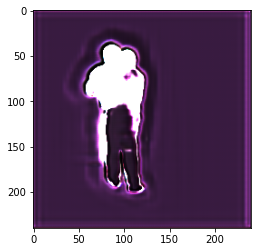

In [39]:
iu.display_image(mask)

In [276]:
ycbcr_image = output[0] * 255
y_image = y_image * 255
ycbcr_image = combine_y_to_cbcr_channel(y_image,cbcr_image)


In [105]:
ycbcr_image


array([[[ 83.        , 115.40117645, 134.60559082],
        [ 69.        , 115.40117645, 134.60559082],
        [ 62.        , 115.40117645, 134.60559082],
        ...,
        [  0.        , 127.86935425, 127.99375916],
        [  0.        , 127.86935425, 127.99375916],
        [  0.        , 127.86935425, 127.99375916]],

       [[ 79.        , 115.40117645, 134.60559082],
        [ 64.        , 115.40117645, 134.60559082],
        [ 61.        , 115.40117645, 134.60559082],
        ...,
        [  0.        , 127.86935425, 127.99375916],
        [  0.        , 127.86935425, 127.99375916],
        [  0.        , 127.86935425, 127.99375916]],

       [[ 53.        , 115.40117645, 134.60559082],
        [ 49.        , 115.40117645, 134.60559082],
        [ 55.        , 115.40117645, 134.60559082],
        ...,
        [  0.        , 127.86935425, 127.99375916],
        [  0.        , 127.86935425, 127.99375916],
        [  0.        , 127.86935425, 127.99375916]],

       ...,

      

In [277]:
rgb_image = iu.ycbcr2rgb(ycbcr_image)


In [106]:
rgb_image

array([[[ 92,  82,  60],
        [ 78,  68,  46],
        [ 71,  61,  39],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[ 88,  78,  56],
        [ 73,  63,  41],
        [ 70,  60,  38],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[ 62,  52,  30],
        [ 58,  48,  26],
        [ 64,  54,  32],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[114, 108,  88],
        [138, 132, 112],
        [143, 137, 117],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[105,  99,  79],
        [130, 124, 104],
        [136, 130, 110],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[ 99,  93,  73],
        [120, 114,  94],
        [128, 122, 102],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

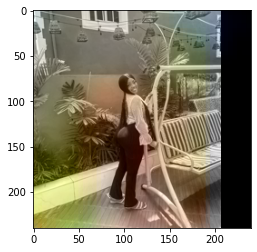

In [278]:
iu.display_image(rgb_image)

In [182]:
def ycbcr2rgb(im):
    xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
    rgb = im.astype(np.float)
    rgb[:, :, [1, 2]] -= 128
    rgb = rgb.dot(xform.T)
    np.putmask(rgb, rgb > 255, 255)
    np.putmask(rgb, rgb < 0, 0)
    return np.uint8(rgb)


In [310]:
image = output[0] * 255
rgb_image =ycbcr2rgb(image)


/var/folders/kh/ldlc522d21lbvxg7zwz8yh8r0000gn/T/ipykernel_67439/1384511715.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rgb = im.astype(np.float)


In [83]:
#test image
test_image = iu.read_image(
    '/Users/ernestopoku-kwarteng/Documents/Pycharm Projects/Anaconda/Machine-Learning/deep-compression/data/nyarumbah_nyamsogoroh~1629383469~2643782611287841652_8213660949.jpg')


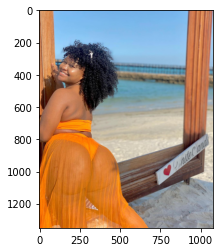

In [84]:
iu.display_image(test_image)


In [85]:
# resize image
new_width, new_height = iu.get_new_image_dimen(test_image, new_dimen)
test_image = test_image.resize((int(new_width), int(new_height)))


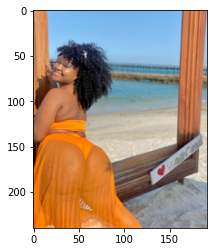

In [86]:
iu.display_image(test_image)


In [87]:
test_image = np.asarray(test_image)


In [88]:
# pad image
test_image = iu.pad_image(test_image, 240)


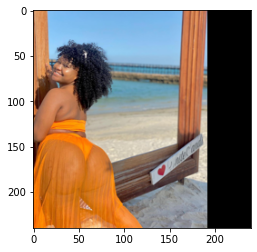

In [89]:
iu.display_image(test_image)


In [90]:
test_image = test_image / 255


In [91]:
output = model.predict(np.array([test_image]))

In [92]:
ycbcr_image = output[0]
ycbcr_image = ycbcr_image * 255

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


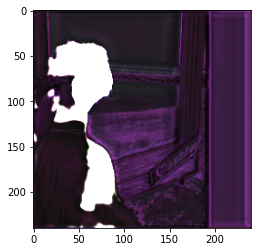

In [93]:
iu.display_image(ycbcr_image)


In [97]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
while cap.isOpened():
    ret, frame = cap.read()
    image_np = np.array(frame)
    image = Image.fromarray(image_np)
    image = image.resize((240, 240))
    image_np = np.array(image) / 255
    output = model.predict(np.array([image_np]))
    mask = output[0] * 255
    image_np_with_detections = mask.copy()
    cv2.imshow('image segmentation',  cv2.resize(
        image_np_with_detections, (240, 240)))

    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break


/Users/ernestopoku-kwarteng/Documents/Pycharm Projects/Anaconda/Machine-Learning/ml-env/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [ ]:
cap.release()
cv2.destroyAllWindows()
